In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp

import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import albumentations as albu
from tensorboardX import SummaryWriter
from attention_unet import AttU_Net
from r2unet import R2U_Net

In [2]:
write = SummaryWriter('logs')
DATA_DIR = '/home/system/datasets/gallbladder1/crop'
x_train_dir = os.path.join(DATA_DIR, 'train/img')
y_train_dir = os.path.join(DATA_DIR, 'train/mask')

x_valid_dir = os.path.join(DATA_DIR, 'val/img')
y_valid_dir = os.path.join(DATA_DIR, 'val/mask')

x_test_dir = os.path.join(DATA_DIR, 'test/img')
y_test_dir = os.path.join(DATA_DIR, 'test/mask')

In [3]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [4]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['0', 'gallbladder']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id).split('.')[0] + '_gt.png' for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
#         image = cv2.resize(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), (256, 256))
#         mask = cv2.resize(cv2.imread(self.masks_fps[i], -1), (256, 256))                 # png16   -1
        image =cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], -1)
#         print(self.class_values)
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
#         mask[mask != 0] = 1
#         print(mask.max())
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        return image, mask
        
    def __len__(self):
        return len(self.ids)

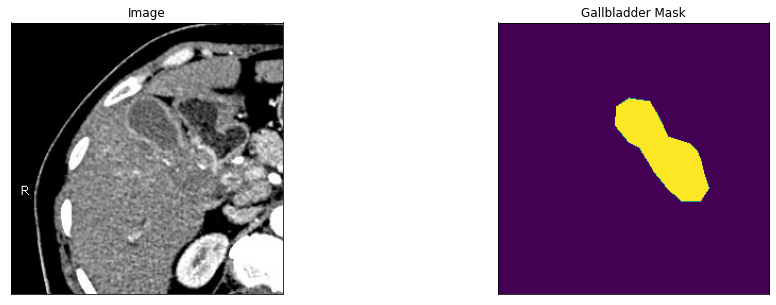

In [5]:
# Lets look at data we have
# mask(0,1)
# image(0,255)
dataset = Dataset(x_test_dir, y_test_dir, classes=['gallbladder'])

image, mask = dataset[4] # get some sample

visualize(
    image=image, 
    gallbladder_mask=mask.squeeze(),
)

In [6]:
def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [7]:
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['gallbladder']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = 'cuda'
write = SummaryWriter('logs')
# create segmentation model with pretrained encoder
# model = smp.Unet(
# #     encoder_name=ENCODER, 
#     encoder_weights=ENCODER_WEIGHTS, 
#     classes=len(CLASSES), 
#     activation=ACTIVATION,
# )
model = R2U_Net(3,1)
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [8]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
#     augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
#     augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=12, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=True, num_workers=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2.64
1.0


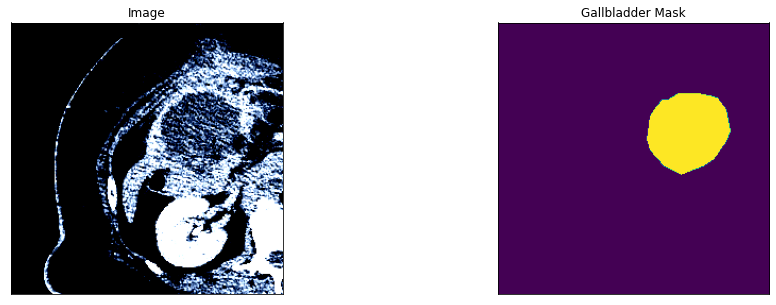

In [9]:
i = 0
for img, msk in train_loader:
    if i == 0:
        img = np.array(img)
        msk = np.array(msk)
        print(img.max())
        print(msk.max())
        visualize(
            image=img[0].transpose(1, 2, 0), 
            gallbladder_mask=msk[0].transpose(1, 2, 0).squeeze(),
        )
    else:
        break
    i+=1

In [10]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index
EPOCHS = 50
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.SGD([ 
    dict(params=model.parameters(), lr=0.1,momentum=0.8),
])
# optimizer = torch.optim.Adam([ 
#     dict(params=model.parameters(), lr=0.1),
# ])
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, EPOCHS, eta_min=1e-6)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 8, 15, 18, 20], gamma=0.1)

In [11]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [12]:
# train model for 40 epochs

max_score = 0

for i in range(0, EPOCHS):
    lr = scheduler.get_last_lr()
    print('\nEpoch: {},lr:{}'.format(i, lr))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './models/r2unet_best_model.pth')
        print('Model saved!')
    scheduler.step()
    write.add_scalars('Train_val_loss', {'train_loss' + str(EPOCHS): train_logs['dice_loss']}, i + 1)
    write.add_scalars('Train_val_loss', {'val_loss' + str(EPOCHS): valid_logs['dice_loss']}, i + 1)
    write.add_scalars('IoU_score', {'train_IoU_score' + str(EPOCHS): train_logs['iou_score']}, i + 1)
    write.add_scalars('IoU_score', {'val_IoU_score' + str(EPOCHS): valid_logs['iou_score']}, i + 1)
    if i < 2:
#         optimizer.param_groups[0]['lr'] = 1e-5
#         print('Decrease decoder learning rate to 1e-5!')
        
        print('valid_logs',valid_logs)
        print('train_logs', train_logs)


Epoch: 0,lr:[0.1]
valid: 100%|██████████| 310/310 [00:33<00:00,  9.27it/s, dice_loss - 0.3304, iou_score - 0.5183]
Model saved!
valid_logs {'dice_loss': 0.33037069574479144, 'iou_score': 0.5182846120768975}
train_logs {'dice_loss': 0.3650414016640302, 'iou_score': 0.481961009494092}

Epoch: 1,lr:[0.1]
valid: 100%|██████████| 310/310 [00:34<00:00,  8.90it/s, dice_loss - 0.3346, iou_score - 0.5144]
valid_logs {'dice_loss': 0.3345988677394005, 'iou_score': 0.5144317662643808}
train_logs {'dice_loss': 0.23817583345672444, 'iou_score': 0.619954021926065}

Epoch: 2,lr:[0.1]
valid: 100%|██████████| 310/310 [00:35<00:00,  8.68it/s, dice_loss - 0.6999, iou_score - 0.1912]

Epoch: 3,lr:[0.1]
valid: 100%|██████████| 310/310 [00:35<00:00,  8.68it/s, dice_loss - 0.2365, iou_score - 0.6268]
Model saved!

Epoch: 4,lr:[0.1]
valid: 100%|██████████| 310/310 [00:34<00:00,  8.87it/s, dice_loss - 0.2332, iou_score - 0.6307]
Model saved!

Epoch: 5,lr:[0.010000000000000002]
valid: 100%|██████████| 310/310 [

valid: 100%|██████████| 310/310 [00:33<00:00,  9.36it/s, dice_loss - 0.2749, iou_score - 0.586] 

Epoch: 35,lr:[1.0000000000000004e-06]
valid: 100%|██████████| 310/310 [00:33<00:00,  9.34it/s, dice_loss - 0.2856, iou_score - 0.5734]

Epoch: 36,lr:[1.0000000000000004e-06]
valid: 100%|██████████| 310/310 [00:33<00:00,  9.33it/s, dice_loss - 0.2731, iou_score - 0.5879]

Epoch: 37,lr:[1.0000000000000004e-06]
valid: 100%|██████████| 310/310 [00:33<00:00,  9.14it/s, dice_loss - 0.2717, iou_score - 0.59]  

Epoch: 38,lr:[1.0000000000000004e-06]
valid: 100%|██████████| 310/310 [00:33<00:00,  9.27it/s, dice_loss - 0.2889, iou_score - 0.5693]

Epoch: 39,lr:[1.0000000000000004e-06]
valid: 100%|██████████| 310/310 [00:33<00:00,  9.31it/s, dice_loss - 0.271, iou_score - 0.59]   

Epoch: 40,lr:[1.0000000000000004e-06]
valid: 100%|██████████| 310/310 [00:33<00:00,  9.16it/s, dice_loss - 0.2585, iou_score - 0.605] 

Epoch: 41,lr:[1.0000000000000004e-06]
valid: 100%|██████████| 310/310 [00:33<00:00,  9

In [13]:
# load best saved checkpoint
best_model = torch.load('./models/r2unet_best_model.pth')

In [14]:
# create test dataset
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
#     augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

In [15]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir, 
    classes=CLASSES,
)

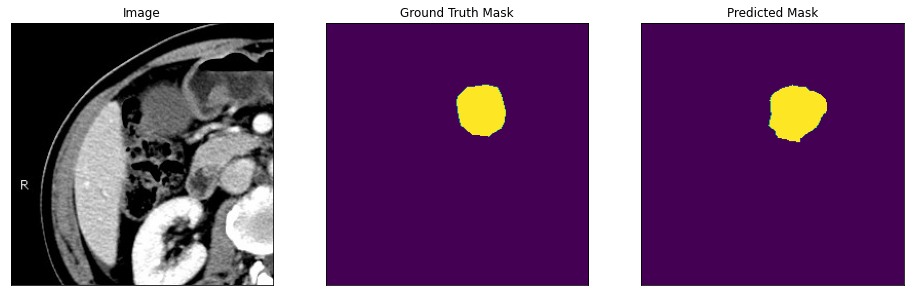

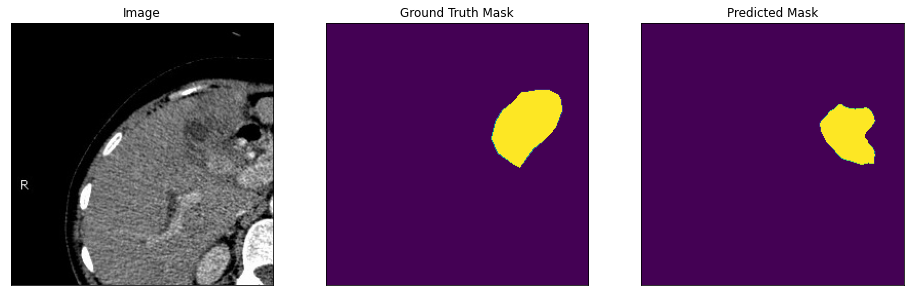

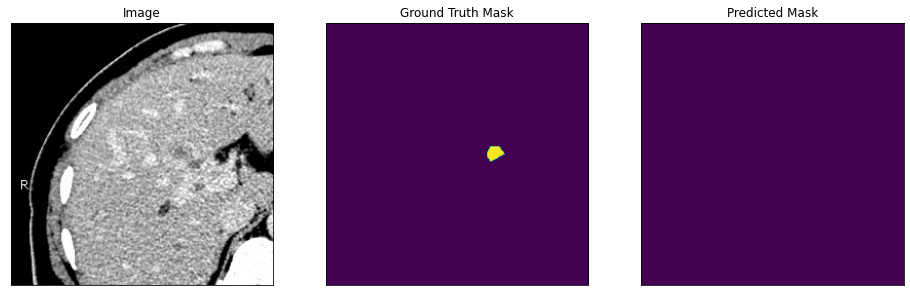

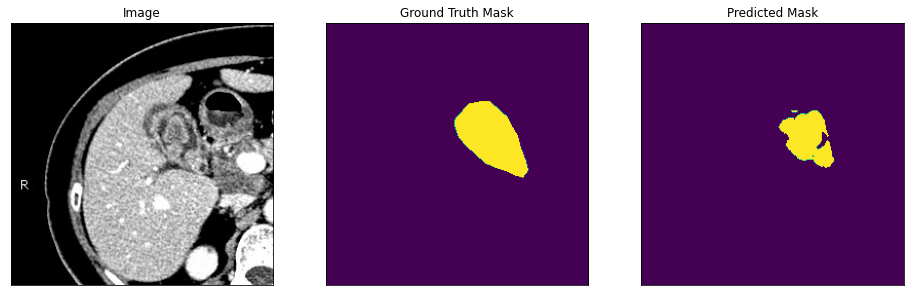

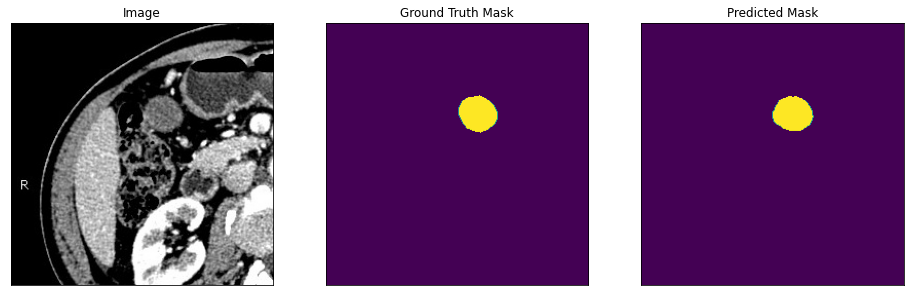

In [16]:
model.eval()
for i in range(5):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    gt_mask[gt_mask != 0] = 1 
    gt_mask[gt_mask == 0] = 0 
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
#     pr_mask = best_model.predict(x_tensor)
    with torch.no_grad():
        
        pr_mask = best_model(x_tensor)
        pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        pr_mask[pr_mask != 0] = 1  
        visualize(
            image=image_vis, 
            ground_truth_mask=gt_mask, 
            predicted_mask=pr_mask
        )